In [204]:
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline
import random
import sys

In [8]:
def RunningProportion(bias=0.5,n=500):
    headprop=np.zeros(n)
    headcount=0
    for i in range(1,n):
        if random.random()>(1-bias):
            headcount += 1
        headprop[i] = float(headcount) / i
    plt.semilogx(headprop,'k.-',markersize=10)
    plt.plot([1,1000],2 * [bias],'r--',lw=2)
    plt.ylim(ymax=1.0)

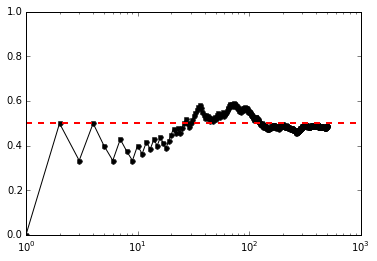

In [9]:
RunningProportion()

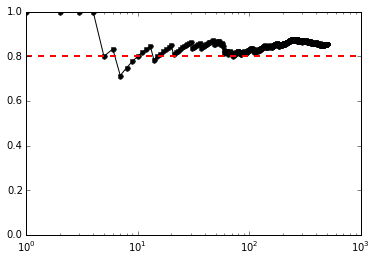

In [10]:
RunningProportion(bias=0.8)

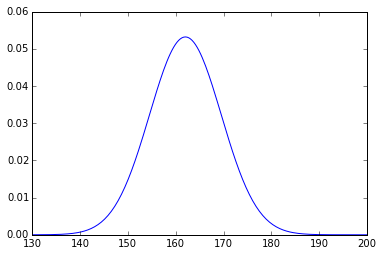

In [42]:
meanval= 162
sdval=7.5
xlow = 130
xhigh=200
dx=1.0
x=np.linspace(xlow,xhigh,xhigh/dx)
p_x = 1/(sdval*np.sqrt(2*np.pi))*np.exp(-.5*((x-meanval)/sdval)**2)
plt.plot(x,p_x)

In [43]:
np.sum(p_x*dx)

2.8428312966572422

In [51]:
(0.25**3)*(0.75**9)*0.25

0.0002932995557785034

In [52]:
(0.5**3)*(0.5**9)*0.5

0.0001220703125

In [53]:
(0.75**3)*(0.25**9)*0.25

4.023313522338867e-07

In [54]:
data = np.repeat([1, 0], [3, 9])

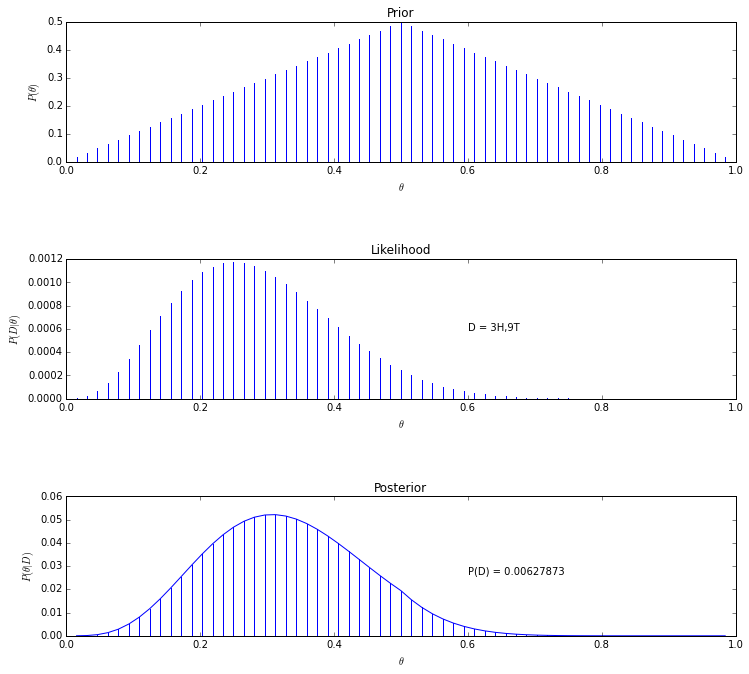

In [71]:
n_theta_vals = 63.
# Now make the vector of theta values:
theta = np.linspace(1/(n_theta_vals +1), n_theta_vals /(n_theta_vals +1), n_theta_vals )
p_theta = np.minimum(theta, 1-theta) 
n_heads = np.sum(data)
n_tails = sum(data==0)
p_data_given_theta = theta**n_heads * (1-theta)**n_tails # ! this is P(D|theta,M)
p_data = sum(p_theta*p_data_given_theta) #note that this is p(D|M) but there's only 1M -> the binomial model
p_theta_given_data = (p_data_given_theta * p_theta) / p_data #So this is P(theta|D,M)
#-------------------------------------------------
# Plot the results.
plt.figure(figsize=(12, 11))
plt.subplots_adjust(hspace=0.7)

# Plot the prior:
plt.subplot(3, 1, 1)
plt.stem(theta, p_theta, markerfmt=' ')
plt.xlim(0, 1)
plt.xlabel('$\\theta$')
plt.ylabel('$P(\\theta)$')
plt.title('Prior')
# Plot the likelihood:
plt.subplot(3, 1, 2)
plt.stem(theta, p_data_given_theta, markerfmt=' ')
plt.xlim(0, 1)
plt.xlabel('$\\theta$')
plt.ylabel('$P(D|\\theta)$')
plt.title('Likelihood')
plt.text(0.6, np.max(p_data_given_theta)/2, 'D = %sH,%sT' % (n_heads, n_tails))
# Plot the posterior:
plt.subplot(3, 1, 3)
plt.plot(theta,p_theta_given_data)
plt.stem(theta, p_theta_given_data, markerfmt=' ')
plt.xlim(0, 1)
plt.xlabel('$\\theta$')
plt.ylabel('$P(\\theta|D)$')
plt.title('Posterior')
_ = plt.text(0.6, np.max(p_theta_given_data)/2, 'P(D) = %g' % p_data)

In [93]:
from scipy.optimize import fmin
def HDIofICDF(dist_name,credMass=0.95, **args):
    """
    HDIofICDF
    This function finds the HDI of a probability density function that is specified
    mathematically in Python.
    """
    # freeze distribution with given arguments
    distri=dist_name(**args)
    # initial guess for HDIlowTailPr
    incredMass = 1.0 - credMass
    
    def IntervalWidth(lowTailPr):
        return distri.ppf(credMass + lowTailPr) - distri.ppf(lowTailPr)
    
    # find lowTailPr that minimizes intervalWidth
    HDIlowTailPr = fmin(IntervalWidth,incredMass,ftol=1e-8,disp=False)[0]
    
    # return interval as array([low,high])
    return distri.ppf([HDIlowTailPr, credMass + HDIlowTailPr])

In [223]:
import sys
from scipy.stats import beta
from scipy.special import beta as beta_func
def BernBeta(priorShape,dataVec,credMass = 0.95,thetaReq = 0):
    
    """ Bayesian updating for Bernoulli likelihood andbetaprior.
        Input arguments:
            priorShape: vector of parameter values for the prior beta distribution.
            dataVec: vector of 1's and 0's.
            credMass: the probability massoftheHDI.
        Output:
            postShape: vectorofparametervaluesfor theposteriorbetadistribution.
        Graphics:
            Creates a three-panel graphofprior, likelihood, and posterior
            with highest posterior density interval.
        Example of use:
            >>>postShape = BernBeta(priorShape=c(1,1),dataVec=c(1,0,0,1,1) )
        
    """
    # Check for errors in input arguments:
    
    if len(priorShape) != 2:
        print "priorShape must have two entries"
        sys.exit(1)
    if any (n < 0 for n in priorShape):
        print " priorShape must have positive entries"
        sys.exit(1)
    if any((n < 0) or (n > 1) for n in dataVec):
        print "dataVec entries must be 0 or 1"
        sys.exit(1)
    
    # Rename prior shape parameters for conv.
    a,b = priorShape
    
    # Create summary values of the data
    Z = sum(dataVec) # number of 1s
    N = len(dataVec) # number of data
    
    # Compute the evidence, p(D):
    pData = beta_func(Z + a, b + N - Z) / beta_func(a,b)
    
    # Construct grid of theta values used for graphing
    bin_width = 0.005 # Arbitrary small value for theta search
    theta = np.arange(bin_width/2, 1-(bin_width/2)+bin_width, bin_width)
    
    # Compute the prior at each value of theta
    p_theta=beta.pdf(theta,a,b)
    
    # Compute the likelihood of the data at each value of theta
    # note that we don't really use this, since the posterior 
    # distribution is easily calculated by changing the shape 
    # parameters by adding the new data (see post_a and post_b)
    p_data_given_theta = theta**Z * (1-theta)**(N-Z) 
    
    
    # Compute the posterior at each value of theta
    post_a = a + Z
    post_b = b + N - Z
    p_theta_given_data = beta.pdf(theta,post_a,post_b)
    
    # Determine the limits of the highest density interval
    intervals = HDIofICDF(beta,credMass,a=post_a,b=post_b)
     
    # Plot the results
    plt.figure(figsize=(12,12))
    plt.subplots_adjust(hspace=0.5)
    
    # Plot the prior
    locx = 0.05
    plt.subplot(3,1,1)
    plt.plot(theta,p_theta)
    plt.xlim(0,1)
    plt.ylim(0,np.max(p_theta) * 1.2)
    plt.xlabel(r'$\theta$')
    plt.ylabel(r'$P(\theta)$')
    plt.title('Prior')
    plt.text(locx,np.max(p_theta) / 2,r'beta($\theta$;%s,%s)' % (a,b))
    
    # Plot the likelihood
    plt.subplot(3,1,2)
    plt.plot(theta,p_data_given_theta)
    plt.xlim(0,1)
    plt.ylim(0,np.max(p_data_given_theta)*1.2)

    plt.xlabel(r'$\theta$')
    plt.ylabel(r'$P(D|\theta)$')
    plt.title('Likelihood')
    plt.text(locx,np.max(p_data_given_theta)/2,'Data: z=%s, N=%s' %(Z,N))
    
    # Plot the posterior
    plt.subplot(3,1,3)
    plt.plot(theta,p_theta_given_data)
    plt.xlim(0,1)
    plt.ylim(0,np.max(p_theta_given_data) * 1.2)
    
    plt.xlabel(r'$\theta$')
    plt.ylabel(r'$P(\theta|D)$')
    plt.title('Posterior')
    
    locy = np.linspace(0,np.max(p_theta_given_data), 6)
    plt.text(locx,locy[1],r'beta($\theta$;%s,%s)' %(post_a,post_b))
    plt.text(locx,locy[2],'P(D) = %g' % pData)
    
    
    #Plot the HDI
    plt.text(locx,locy[3],
           'Intervals = %.3f - %.3f' % (intervals[0],intervals[1]))
    plt.fill_between(theta,0,p_theta_given_data,
                    where=np.logical_and(theta > intervals[0],theta < intervals[1]),color='blue',alpha=0.3)
    
    # Plot vline for theta_max_prob or any requested theta
    if thetaReq > 0:
        
        if thetaReq  >= 1: 
            
            markX =theta[p_theta_given_data.argmax()]
            markY = np.max(p_theta_given_data)
            plt.text(locx,locy[4],
                 r'$P(\theta|D)_{max} = \ %.3f \ at \ \theta \ = \ %.3f$' 
                     %(markY,markX),color='r',fontsize=16)
            
            if thetaReq == 2:
                markYY = np.sum(p_theta_given_data*theta)
                plt.text(locx,locy[5],r'$\theta_{mean} = %.3f$'%markYY,color='b',fontsize = 16)
        else:
            
            markX = thetaReq
            idx = (np.abs(theta-thetaReq)).argmin()
            markY = p_theta_given_data[idx]
                       
            plt.text(locx,locy[4],
                     r'$P(\theta = %.3f|D) = \ %.3f$' 
                     %(markX,markY),color='r',fontsize=16)
        
        plt.vlines(markX,0,markY,'r',linestyles='--')
    
    return [post_a,post_b]

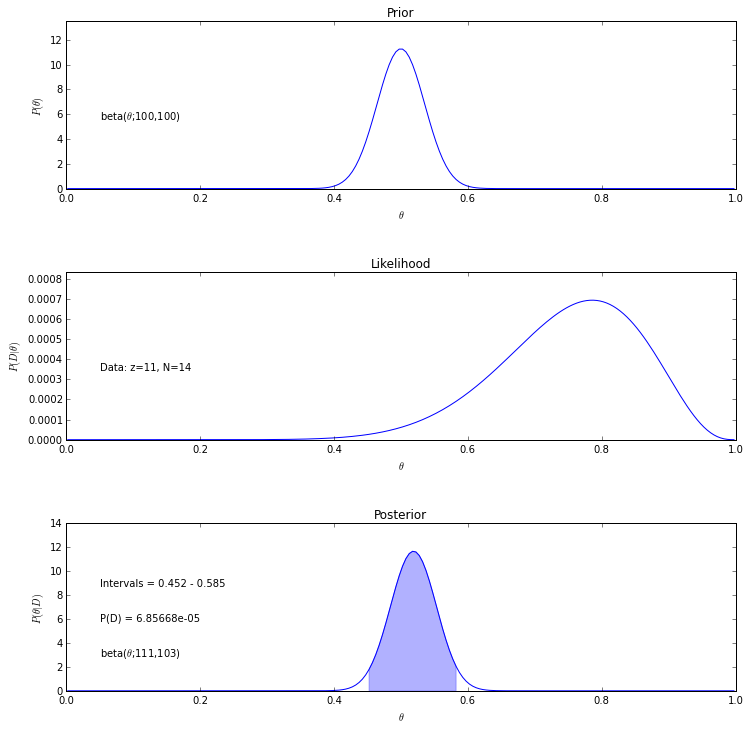

In [149]:
datavec=np.repeat([1,0],[11,3])

post = BernBeta([100,100],dataVec=datavec)

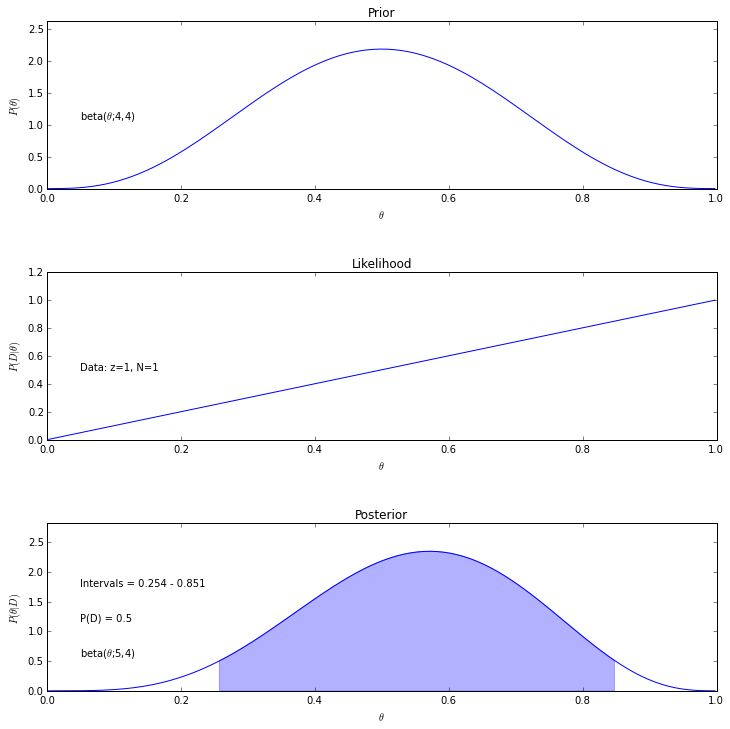

In [150]:
dv = [1]
priorShape=[4,4]
post=BernBeta(priorShape,dataVec=dv)

In [151]:
post

[5, 4]

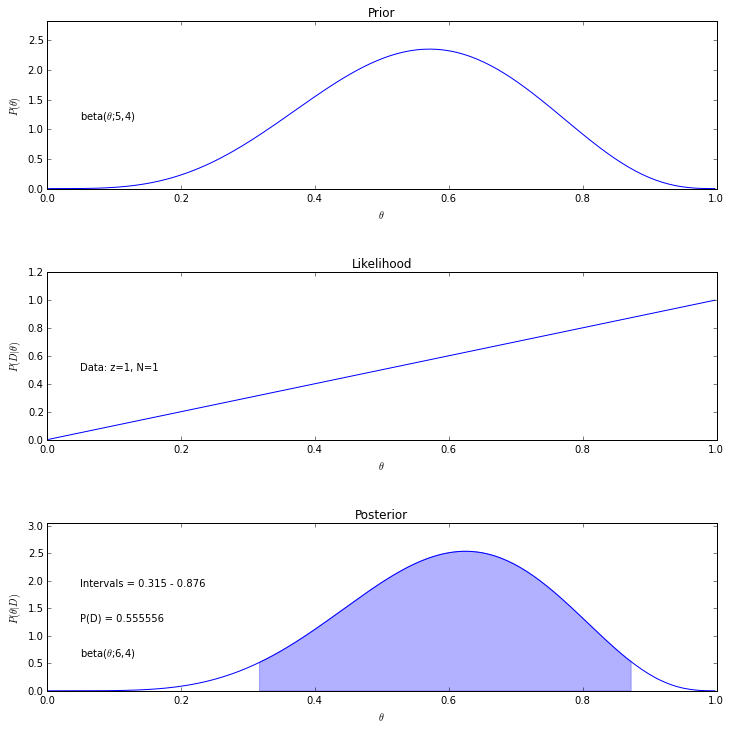

In [152]:
post2=BernBeta(post,dataVec=[1])

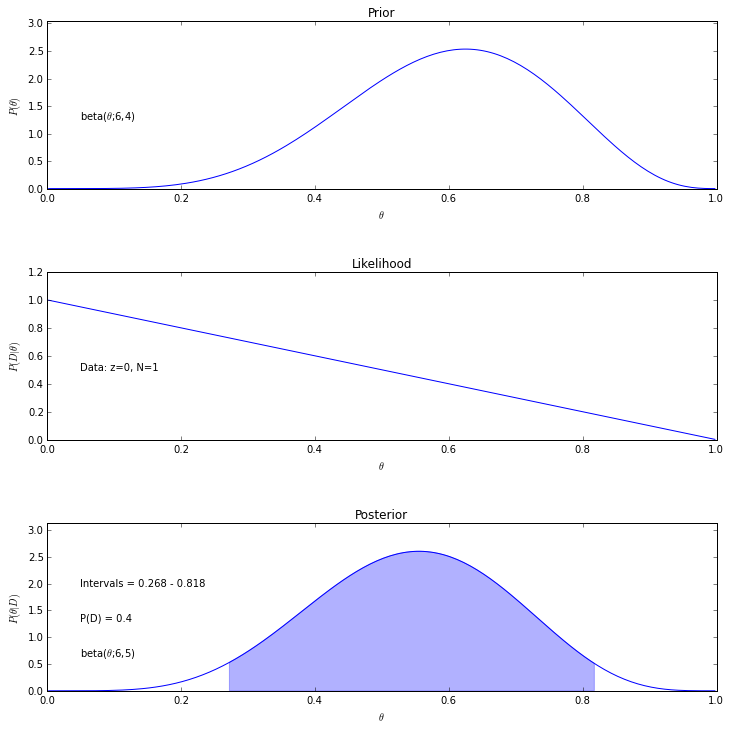

In [153]:
post3=BernBeta(post2,dataVec=[0])

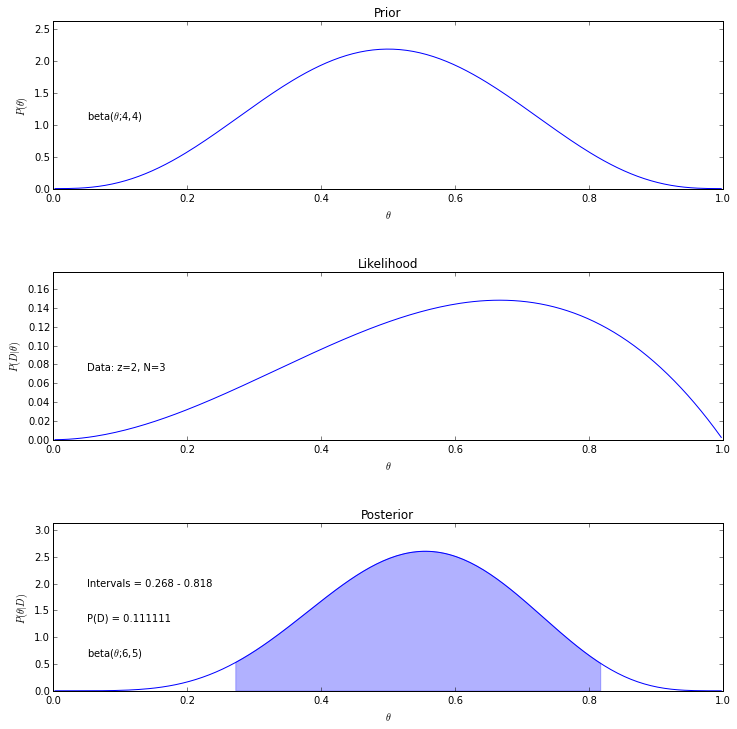

In [154]:
npost=BernBeta(priorShape,dataVec=[1,1,0])

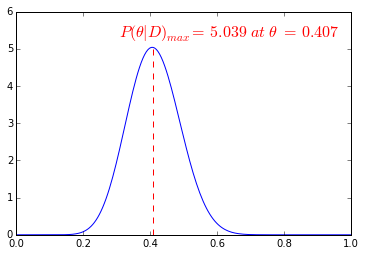

In [173]:
plt.plot(theta,p_theta_given_data)
maxX =theta[p_theta_given_data.argmax()]
maxY = np.max(p_theta_given_data)
plt.vlines(maxX,0,maxY,'r',linestyles='--')
plt.text(maxX-0.1,5.3,r'$P(\theta|D)_{max} = \ %.3f \ at \ \theta \ = \ %.3f$' %(maxY,maxX),color='r',fontsize=16)

In [156]:
np.max(p_theta_given_data)

5.0386276478746002

In [174]:
type(beta)

scipy.stats._continuous_distns.beta_gen

In [221]:
del p_theta_given_data

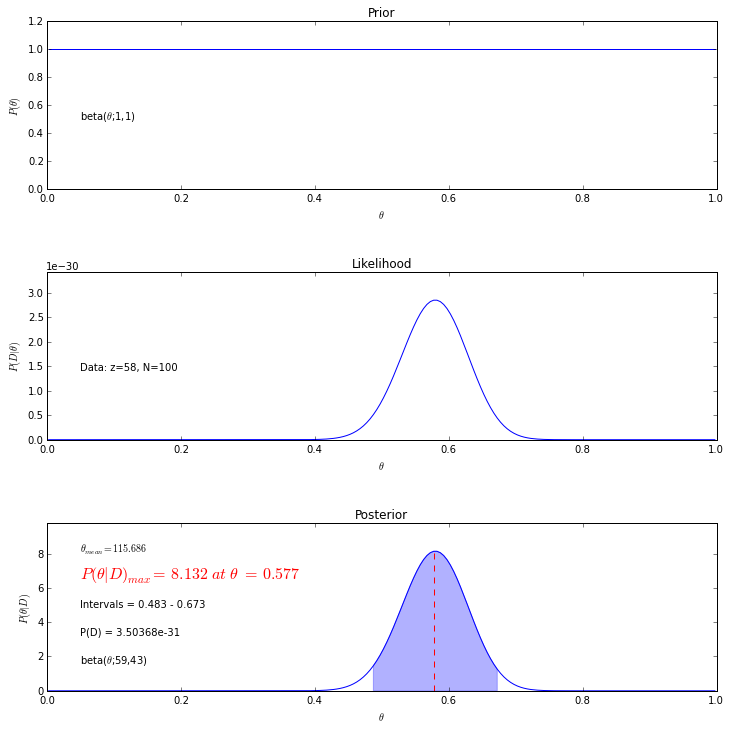

In [222]:
#Ex. 5.2
priorShape = [1,1]
datavec=58*[1] + 42*[0];
post = BernBeta(priorShape,dataVec=datavec,thetaReq=2)

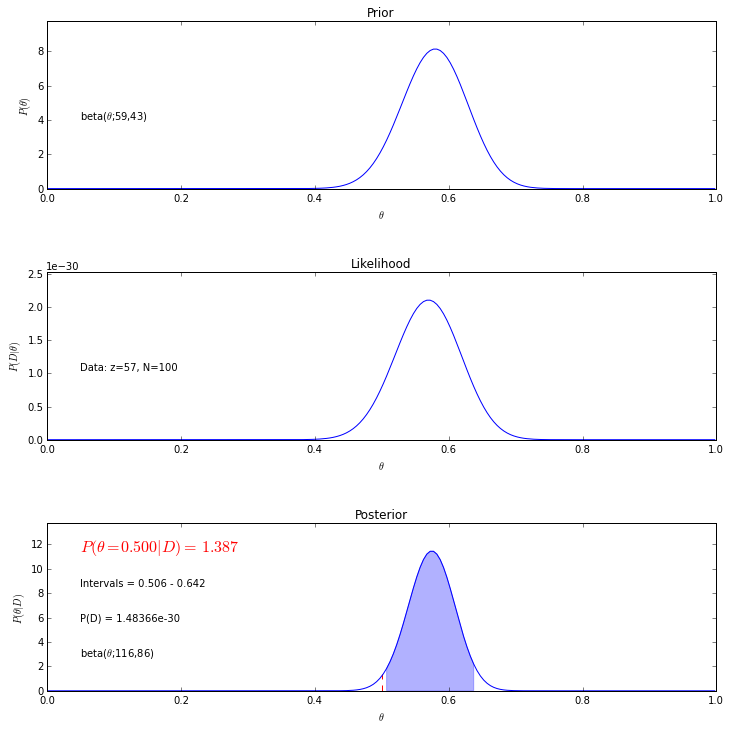

In [200]:
datavec=57*[1]+43*[0]
newPost=BernBeta(post,datavec,thetaReq=0.5)

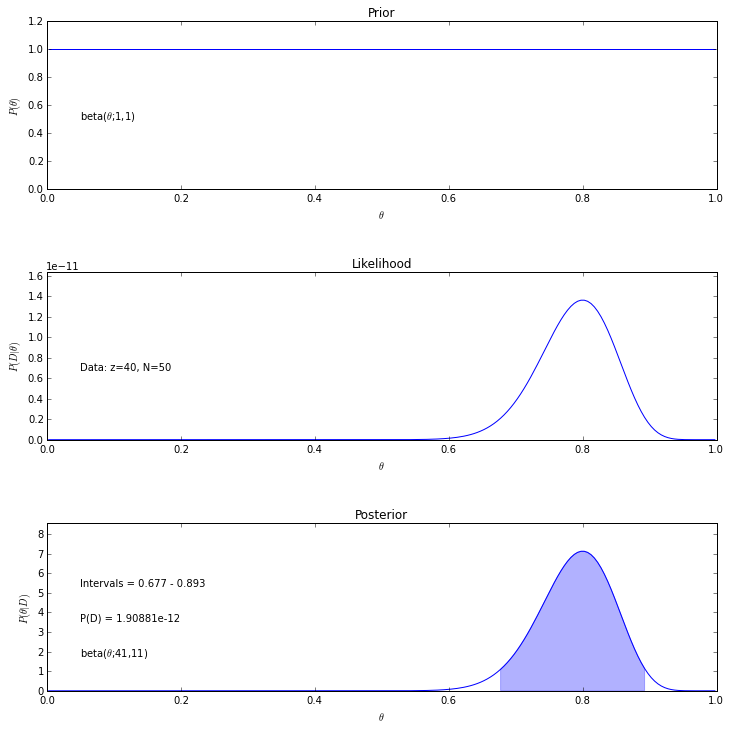

In [201]:
#Ex. 5.3
pr=[1,1]
dataVec=40 * [1] + 10 * [0]
post = BernBeta(pr,dataVec=dataVec)

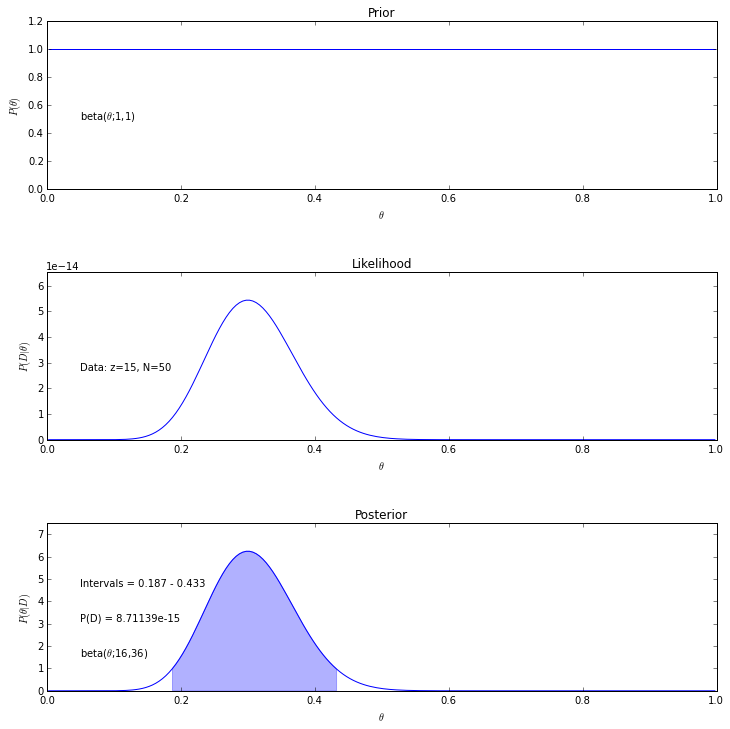

In [203]:
np2=BernBeta([1,1],dataVec=datavec)

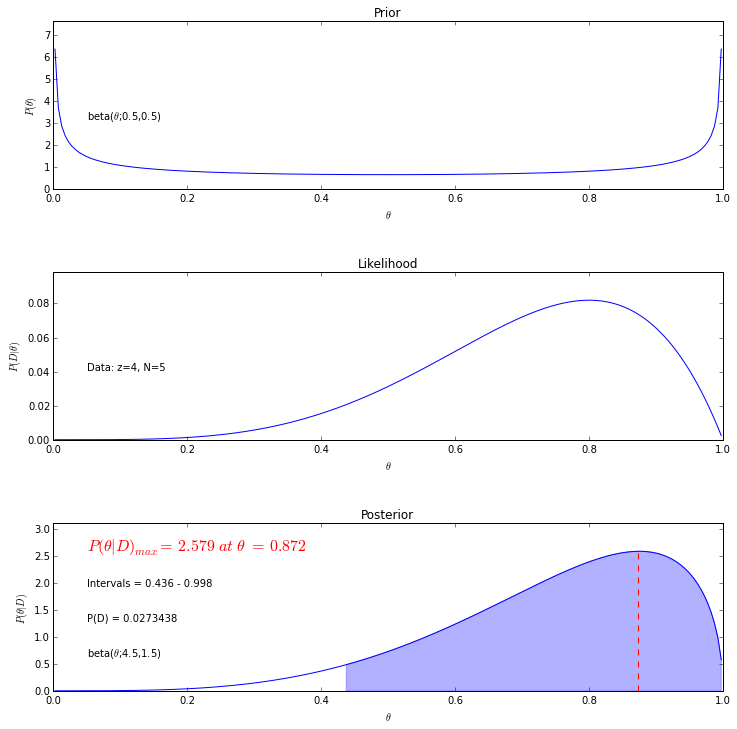

In [206]:
# Ex. 5.4
prShp = [0.5,0.5]
dv = 4 * [1] + [0]
post=BernBeta(prShp,dataVec=dv,thetaReq=1)

0.863636363636


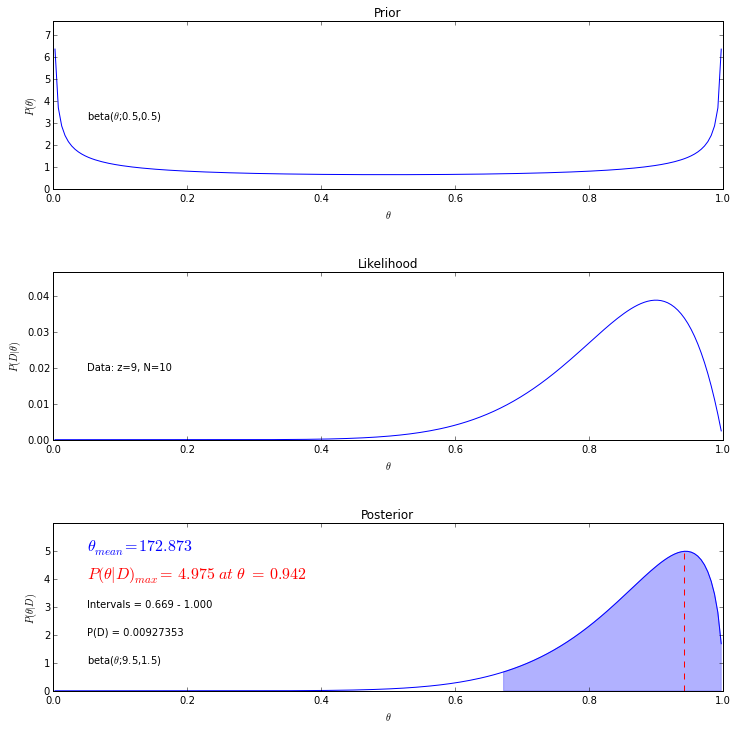

In [226]:
#Ex5.5
from __future__ import division

# first case
#a = 50 
#b = 50
# second case
a = 0.5
b = 0.5
prShp = [a,b]
N  = 10
z = 9
dv = z * [1] + (N - z) * [0]
#predicted value is mean of posterior, i.e. z+a / (N + a +b)
# (note that mean of prior is a / (a + b))
print (z + a) / (N + a + b)
post = BernBeta(prShp,dataVec=dv,thetaReq=2)

In [209]:
#Ex5.6
from __future__ import division

a_tc = 0.5
b_tc = 0.5
a_fc = 1
b_fc = 1
trickCoinPrior=[a_tc,b_tc]
fairCoinPrior = [a_fc,b_fc]
N = 20
z = 15
dv = z * [1] + (N-z) * [0]
evid_Mdl1 = beta_func(a_tc+z,b_tc+N-z)/beta_func(a_tc,b_tc)
evid_Mdl2 = beta_func(a_fc+z,b_fc+N-z)/beta_func(a_fc,b_fc)
print evid_Mdl1/evid_Mdl2

0.746587753238


In [210]:
#the evidence points to the trick coin model being a better one.

In [232]:
#Ex5.7

def evidence(a,b,z,N):
    # This function is useful for both 5.7 and 5.8
    return beta_func(a + z , b + N - z) / beta_func(a , b)

a1,b1 = 1, 100
a2,b2 = 100,1
N,z = 1,1
print evidence(a1,b1,z,N)
print evidence(a2,b2,z,N)
print evidence(a1,b1,z,N) / evidence(a2,b2,z,N)

0.00990099009901
0.990099009901
0.01


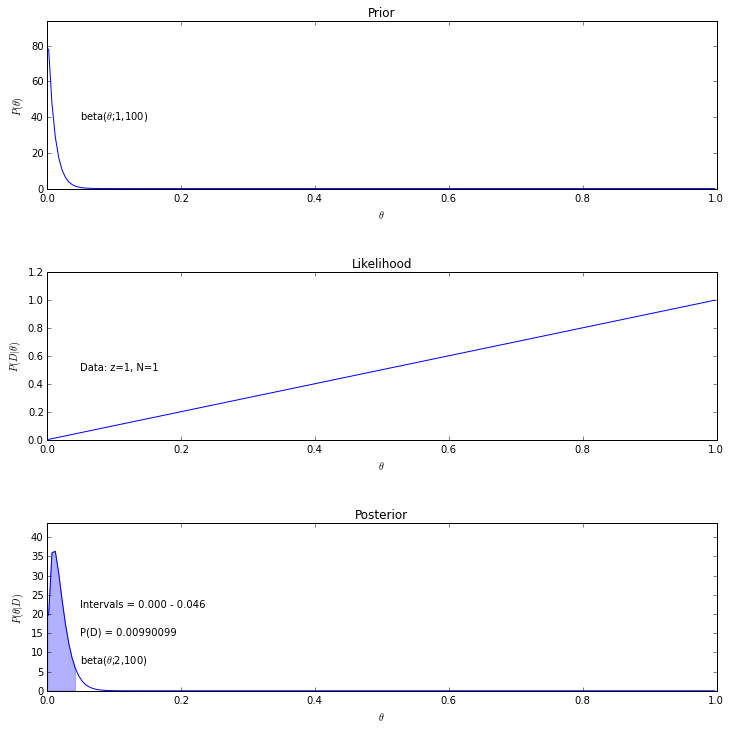

In [229]:
p1=BernBeta([a1,b1],dataVec = [1])

[101, 1]

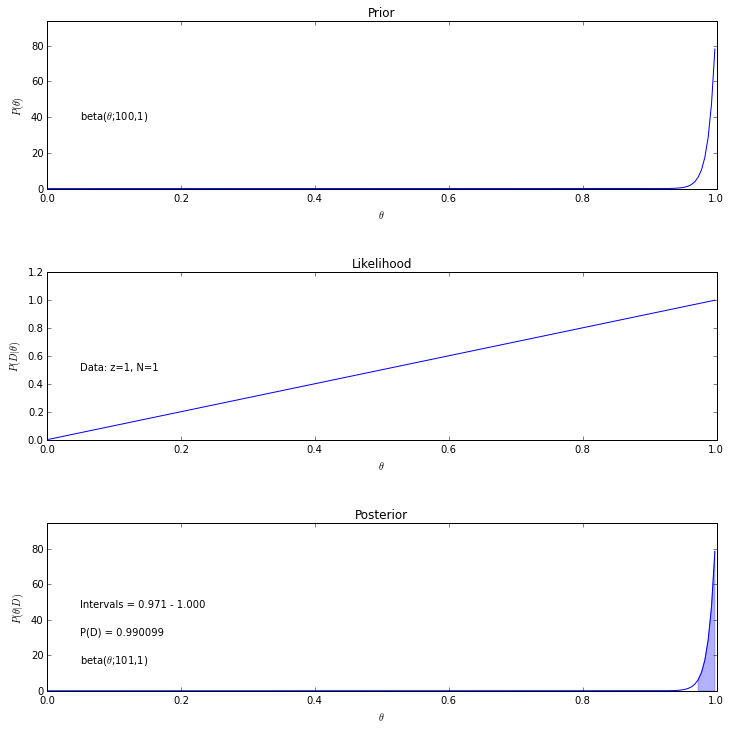

In [231]:
BernBeta([a2,b2],dataVec=[1])

2.02220091274e-12
1.4908271789e-07
1.35642879427e-05


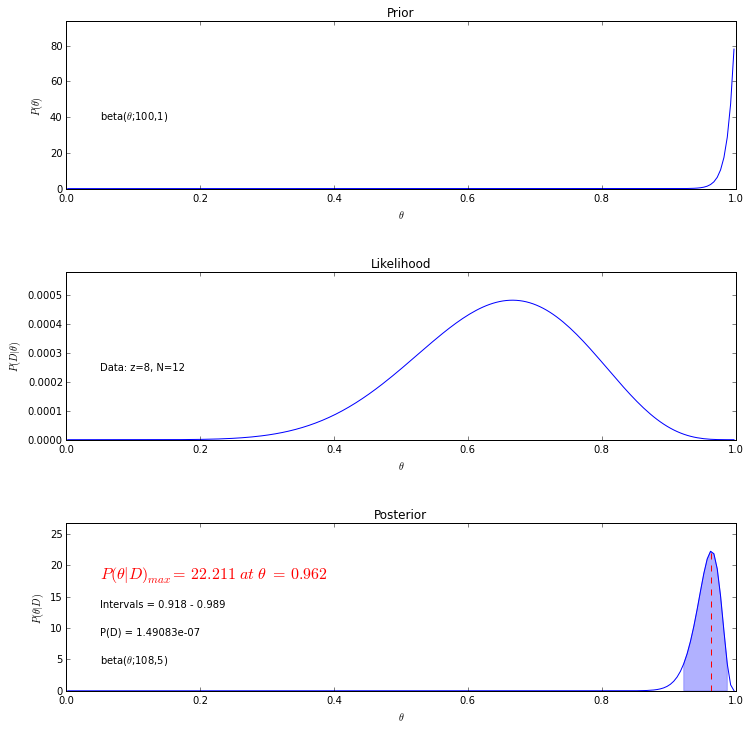

In [241]:
#Ex5.8
a1,b1 = 1, 100
a2,b2 = 100,1
N,z = 12,8
print evidence(a1,b1,z,N)
print evidence(a2,b2,z,N)
print evidence(a1,b1,z,N) / evidence(a2,b2,z,N)
dv = z*[1]+(N-z)*[0]
p=BernBeta([a2,b2],dataVec=dv,thetaReq=1)

In [234]:
# clearly model 2 is winning. But that it is the BETTER model does NOT NECESSARILY mean it is a GOOD model
# To verify this:
#                 => we simulate data sampled from the second model
#                 => see if the simulated data "looks" like the actual data
# To simulate data:
#                 1 - we randomly generate a theta from the posterior distribution of the winning model
#                 2 - using that theta, generate new (simulated) data set
#                 3 - summarize simulated data and see how it compares to the actual data

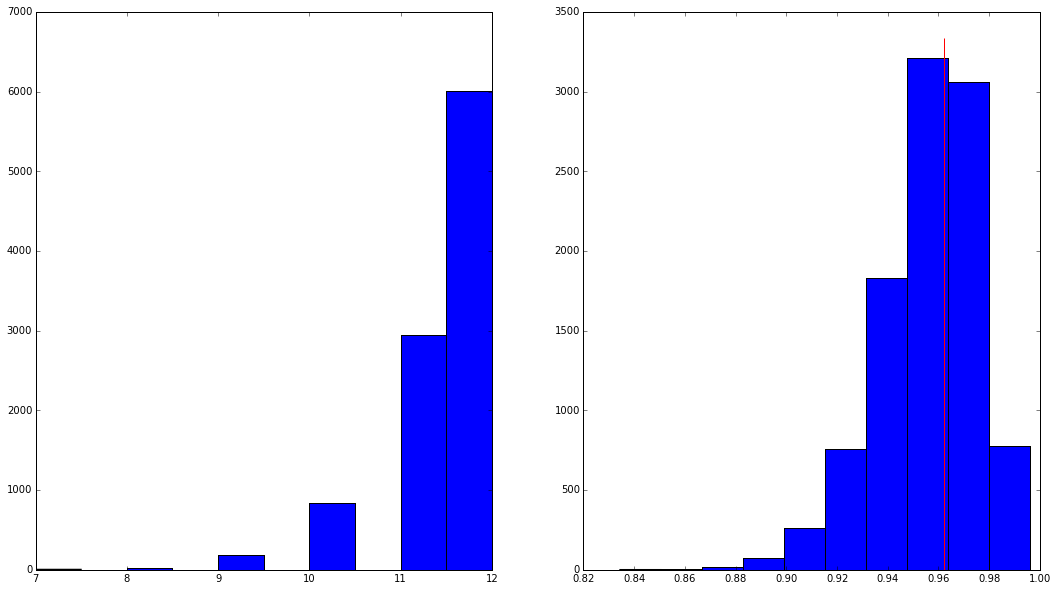

In [243]:
# First specify known values of prior and actual data
priorA = a2
priorB = b2
actualZ = z
actualN = N
# Compute posterior parameter values:
postA = priorA + actualZ
postB = priorB + actualN - actualZ
# Number of flips in the simulated sample should match the actual sample size:
simSmplSiz = actualN
# Designate an arbitrarily large number of simulated samples
nSimSamples = 10000
# Set aside a vector in which to store the simulation results.
simSampZrecs = np.zeros(nSimSamples)
simThetarecs = np.zeros(nSimSamples)
for sampidx in range(nSimSamples):
    # Generate a theta value for the new sample from the posterior
    sampTheta = beta.rvs(postA,postB)
    simThetarecs[sampidx] = sampTheta
    # Generate a sample using sampTheta
    sampleData = np.random.choice([0,1],p=[1-sampTheta,sampTheta],size=simSmplSiz,replace=True)
    simSampZrecs[sampidx] = np.sum(sampleData)
#make a histogram of the number of heads in the samples.
plt.figure(figsize=(18,10))
plt.subplot(1,2,1)
plt.hist(simSampZrecs)
plt.subplot(1,2,2)
plt.hist(simThetarecs)
plt.vlines(0.962,ymin=0,ymax=nSimSamples/3.0,color = 'r')